# Q7

Consider a Barberis, Huang, and Santos economy (without the house money effect) where the representative investor has δ = 0.99 and γ = 1 and λ = 2.

Suppose that aggregate consumption growth has lognormal distribution with rare disasters:


Here ε is a standard normal random variable, while η is an independent random variable that represents the effect of rare disasters: η = ln(0.7) with probability of 2.4%, or zero otherwise.

Simulate the distribution for consumption growth with (at least) 104 random draws for ε and η. Calculate and report the mean and the standard deviation of the simulated distribution for consumption growth.

Calculate and report the risk-free rate for this economy.

Use bisection search (with absolute error of no more than 10-5  at convergence) to find the price-to-dividend ratio (P/D) for the market portfolio, for b0 in the range from 0 to 10, in increments of 0.1 (or less). Plot P/D vs b0.

Calculate the equity premium, and plot the equity premium vs b0.

Briefly explain (in words) how to extend the model to incorporate the house money effect.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplot, scatter, plot, axis
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

# Datetime
import datetime as dt
from datetime import datetime
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")

In [2]:
# initialize variables
n_simulations = 100000

In [3]:
delta = 0.99            # Discount factor
gamma = 1               # Coefficient of relative risk aversion
lamda = 2               # Degree of loss aversion

In [4]:
# Note: This assumes that consumption grows at 2% a year with a standard deviation of 2%

def consumption_growth (epsilon, nu):
    growth = np.exp(0.02 + 0.02*epsilon + nu)           # can change consumption growth rate and standard deviation here
    return growth

In [5]:
columns = ["epsilon",
           "nu",
           "growth",]

In [6]:
# Create dataframe to store simulation results

Simulation_df = pd.DataFrame(index=range(n_simulations), columns=columns)

Simulation_df["epsilon"] = np.random.normal(0, 1, (n_simulations))

Simulation_df["nu_draw"] = np.random.uniform(0, 1, (n_simulations))

# pi is the proability of rare disasters in a given year
# phi is the fraction of output that remains after disaster
Simulation_df["nu"] = np.where(Simulation_df["nu_draw"] <= 0.024, np.log(0.70), 0)          # can change probability of rare disasters, amount that is left after disaster

Simulation_df["growth"] = consumption_growth (Simulation_df["epsilon"], Simulation_df["nu"])

# mean and the standard deviation of the simulated distribution for consumption growth

In [15]:
mean_consumption_growth = Simulation_df["growth"].mean()
mean_consumption_growth

1.0128443277473302

In [16]:
std_consumption_growth = Simulation_df["growth"].std()
std_consumption_growth

0.051359255696329334

# Risk-free rate for this economy

In [7]:
# See Lesson 8 Slide 8

rf = 1 / (delta * np.mean(np.array(Simulation_df["growth"]) ** - gamma))

In [8]:
rf

1.0195527200746188

In [9]:
def expected_utility_calc(kappa, g):

    # https://numpy.org/doc/2.1/reference/generated/numpy.where.html
    Eu = \
        np.mean(
            np.where(
                kappa * g >= rf,       # If return higher than risk-free rate
                kappa * g - rf,        # Utility is just return minus risk free rate
                2 * (kappa * g - rf)   # Otherwise, utility is twice as impacted # (lamda) Degree of loss aversion
            )
        )

    return Eu

In [10]:
def error(b, 
          utility, 
          kappa):

    err = delta * b * utility + delta * kappa - 1     # (delta) Discount factor
    
    return err

In [11]:
# This is the time varying scale factor to ensure that amount of utility from consumption remains similar to 
# amount of utility from recent gain or loss over different time intervals.
# Use marginal utility of aggregate consumption as scale factor
# b0 ≥ 0 determines extent to which utility from recent financial gain or loss contributes to investor’s lifetime utility

b =  \
    np \
        .linspace(
            start = 0, 
            stop = 10, 
            num = 1001
        )

In [12]:
kappa_results = []

for i in b:
    
    # confirm that solution lies between start and end
    start = 1
    end = 1.1

    start_utility = \
        expected_utility_calc(
            kappa = np.full((1, n_simulations), start), 
            g = Simulation_df["growth"].values
            )
    
    end_utility = \
        expected_utility_calc(
            kappa = np.full((1, n_simulations), end), 
            g = Simulation_df["growth"].values
        )

    # If errors are of the same sign
    if (error(i, start_utility, start) * error(i, end_utility, end)) > 0:
    
        print('solution does not lie between kappa_ and kappa+')

    error_term = 999

    # bisection search, while absolute of error term greater than
    while abs(error_term) > 10e-5:

        # set kappa as mid of start and end
        kappa0_single = 0.5 * (start + end)

        # create array of kappa to multiply with simulated consumption growth
        kappa0 = np.full((1, n_simulations), kappa0_single)

        # calculate the E(v(kappa * g))
        Eu = expected_utility_calc(kappa = kappa0,
                                   g = Simulation_df["growth"].values)

        # calculate error term
        error_term = error(b = i,
                           utility = Eu, 
                           kappa = kappa0_single)

        # if error term < 0 means kappa < answer < 1.1, shift start point to kappa0_single
        if error_term < 0:

            start = kappa0_single

        # if error term > 0 means 1 < answer < kappa, shift end point to kappa0_single
        if error_term > 0:
            
            end = kappa0_single

        # if error term converge than thats the kappa
        if abs(error_term) < 10e-5:

            kappa_results.append(kappa0_single)

In [13]:
# creating df 
df = pd.DataFrame(kappa_results).rename(columns = {0 : 'kappa'})

df['b'] = b

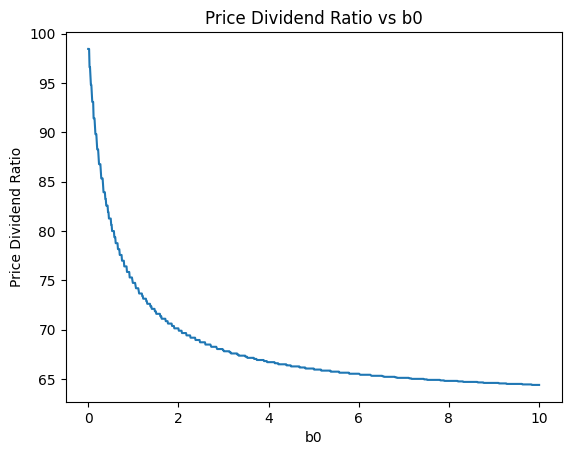

In [17]:
# plotting price dividend ratio

df['price_dividend_ratio'] = 1 / (df["kappa"] - 1)

plt.plot(
    df["b"], 
    df["price_dividend_ratio"]
    )

plt.xlabel('b0')

plt.ylabel('Price Dividend Ratio')

plt.title('Price Dividend Ratio vs b0');

In [18]:
df['expected_market_return'] = df.kappa * np.exp(0.0202)       # Expected market return

# Deduct rf from equity return to get equity risk premium
df['equity_premium'] = df['expected_market_return'] - rf       # Equity risk premium

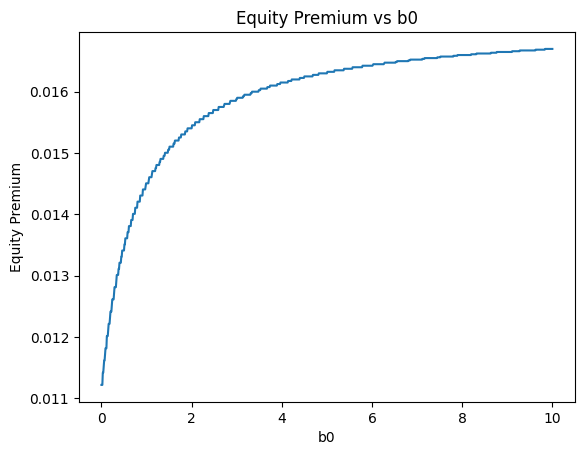

In [19]:
# Deduct rf from equity return to get equity risk premium
plt.plot(df["b"], df['equity_premium'])

plt.xlabel('b0')

plt.ylabel('Equity Premium')

plt.title('Equity Premium vs b0');

# House Money Effect

House money effect is an effect where investors are more willing to gamble after prior gains and less willing to gamble after prior losses. To extend the model for house money effect, we allow investors to keep track of accumulated financial gain or loss over entire lifetime. If they have a (relative) gain, loss aversion is lower. If they have a relative loss, risk aversion is higher.